In [ ]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron

In [1]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 12}
mpl.rc('font', **font)

import numpy as np
import pandas as pd
from scipy import stats

import scprep
import phate
import meld
import graphtools as gt
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.manifold import TSNE
import umap
import time

## Generate Synthetic Data with Known Ground Truth

### Introduction to Splatter

Splatter, [Zappia L, et al. Genome Biology. 2017](https://doi.org/10.1186/s13059-017-1305-0), is a tool for simulating single-cell RNA-sequencing data with a known topology. Splatter has two main modes: "paths" and "groups." Because we're interested in generating data with a known trajectory structure, we are going to use the `paths` mode.

Splatter has a bunch of other parameters you can choose from, and if you have time, feel free to play around with the various options.



#### Generating simulated data

Unfortunately, Splatter is only implemented in R. Fortunately, we provide a wrapper in the `scprep.run` module. You can call Splatter from Python using [`scprep.run.SplatSimulate()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate).

In [2]:
# Run Splatter

# You can easily change the number of paths and cells here
n_paths = 1
cells_per_path = 1000

# Splatter returns a `dict` objbect that contains a bunch of useful information
results = scprep.run.SplatSimulate(
                        method='paths', 
                        batch_cells=cells_per_path * n_paths, 
                        group_prob=np.tile(1/n_paths, n_paths), 
                        n_genes=5000, 
                        seed=42)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


Let's check what we can find in this `results` dictionary. Note, you can find explanations of what each key refers to by checking the `returns` section of the `SplatSimulate` docstring or consulting https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate.

In [3]:
results.keys()

dict_keys(['counts', 'group', 'step', 'batch', 'exp_lib_size', 'base_gene_mean', 'outlier_factor', 'batch_cell_means', 'base_cell_means', 'bcv', 'cell_means', 'true_counts', 'dropout', 'de_fac_1', 'sigma_fac_1'])

 Next, grab the simulated `'counts'`, the ground truth progression along each path or `'step'`, and the `'group'` to which each cell belongs. As earlier, we're going to put the counts data in a `DataFrame` called `data` and the associated metadata for each cell in a `DataFrame` called `metadata`.

In [8]:
# Put counts data in DataFrame
data = pd.DataFrame(results['counts'])

# Put metadata in a DataFrame
metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).T
metadata = metadata.astype({'step': int}) # These are strings by default, but we want ints

# Change DataFrame index names to be a little nicer
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# Library-size normalize and sqrt transform
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)

#### Visualizing the data

Splatter is designed to generate data that can be easily visualized using PCA. If you have time, try to visualize the data using other tools from our visualization module.

In [9]:
data_pca = PCA(100).fit_transform(data)
data_pca = pd.DataFrame(data_pca, index = data.index)

Plot the data using `scprep.plot.scatter2d()`.

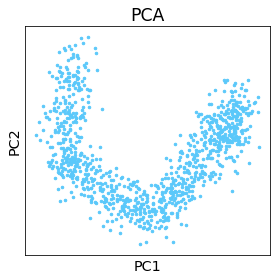

In [13]:
ax = scprep.plot.scatter2d(data_pca, color='#5ac8fa',
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(4,4))

ax.figure.tight_layout()

#### Assign each cell to a day using a binomal distribution

In [160]:
sample = np.random.binomial(2, metadata['step'] / 100, size=1000)
sample = ['Day{}'.format(i+1) for i in sample]


sample_cmap = {'Day1' : '#a8ddb5',
       'Day2': '#4eb3d3',
       'Day3': '#08589e'}


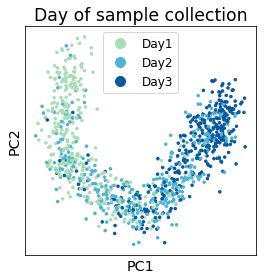

In [271]:

ax = scprep.plot.scatter2d(data_pca, label_prefix='PC', c=sample,
                           cmap=cmap,
                      ticks=None, title='Day of sample collection', 
                      legend=True, figsize=(3.8,4))

ax.figure.tight_layout()

ax.figure.savefig('../img/graph_walk.simulation.samples.png', dpi=300)

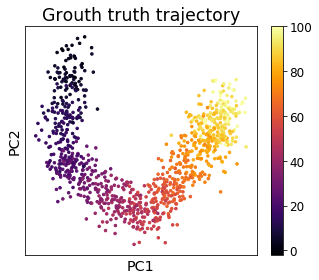

In [269]:
ax = scprep.plot.scatter2d(data_pca, label_prefix='PC', c=metadata['step'],
                      vmin=-2, ticks=None, title='Grouth truth trajectory', 
                      discrete=False, legend=True,
                     figsize=(4.6,4))
ax.figure.tight_layout()
ax.figure.savefig('../img/graph_walk.simulation.ground_truth_trajectory.png', dpi=300)

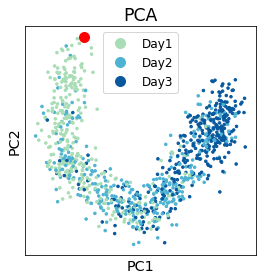

In [292]:
cmap = {'Day1' : '#a8ddb5',
       'Day2': '#4eb3d3',
       'Day3': '#08589e'}

fig, ax = plt.subplots(1, figsize=(3.8,4))

start_cell = np.argsort(metadata['step'])[2]
ax.scatter(data_pca.iloc[start_cell,0], data_pca.iloc[start_cell,1], color='red', zorder=10, s=100)
                      

scprep.plot.scatter2d(data_pca, label_prefix='PC', c=sample,
                           cmap=cmap,
                      vmin=-2, ticks=None, title='PCA', 
                      legend=True, ax=ax)

fig.tight_layout()
fig.savefig('../img/graph_walk.simulation.samples_and_start.png', dpi=300)

In [216]:
import networkx as nx
import sklearn

A = sklearn.neighbors.kneighbors_graph(data_pca, n_neighbors=3).toarray()
G = nx.Graph(A)

In [250]:
A.shape

(1000, 1000)

In [278]:
all_dists = []
for k in range(5,30):
    
    A = sklearn.neighbors.kneighbors_graph(data_pca.iloc[:,:2], n_neighbors=k).toarray()
    G = nx.Graph(A)
    D = np.ones((A.shape[0],A.shape[0])) * -1
    p = nx.shortest_path_length(G, source=start_cell)
    
    dists = np.array([p[i] for i in range(A.shape[0])])
    dists = dists / np.max(dists)
    
    all_dists.append(dists)

all_dists = np.vstack(all_dists).mean(axis=0)

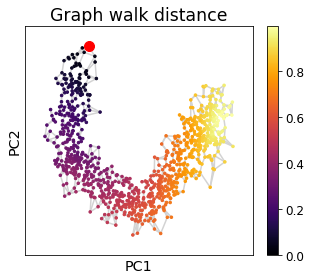

In [294]:
fig, ax = plt.subplots(1, figsize=(4.5,4))

start_cell = np.argsort(metadata['step'])[2]
ax.scatter(data_pca.iloc[start_cell,0], data_pca.iloc[start_cell,1], 
           color='red', zorder=10, s=100)
                      

scprep.plot.scatter2d(data_pca, label_prefix='PC', c=all_dists,#D[start_cell],
                           ticks=None, title='Graph walk distance', 
                      discrete=False, legend=True, ax=ax)


# This block of code draws lines between each point and its k-nearest neighbors
A = sklearn.neighbors.kneighbors_graph(data_pca.iloc[:,:2], n_neighbors=4).toarray()

for i, pt in data_pca.iloc[:,:2].iterrows():
    i = int(i[5:])
    neighbors = np.where(A[i] > 0)[0][1:]
    for nn in neighbors:
        nn_coordinates = data_pca.iloc[nn,:2]
        ax.plot([pt[0], nn_coordinates[0]], [pt[1], nn_coordinates[1]],
               color='lightgrey', zorder=0)

fig.tight_layout()
fig.savefig('../img/graph_walk.simulation.graph_walk_distance.png', dpi=300)

In [286]:
pt

0   -9.789269
1    9.623773
Name: cell_0, dtype: float64

In [272]:
# This block of code draws lines between each point and its k-nearest neighbors
for i, pt in enumerate(data_pca.iloc[:,:2]):
    neighbors = np.where(A[i] > 0)[0][1:]
    for nn in neighbors:
        nn_coordinates = data_pca.iloc[nn,:2]
        ax.plot([pt[0], nn_coordinates[0]], [pt[1], nn_coordinates[1]],
               color='lightgrey', zorder=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [275]:
np.where(A[i] > 0)[0]

array([  0,   3,  21,  27,  33,  34,  36,  49,  56,  62,  69,  73,  76,
        87,  93, 111, 117, 122, 127, 134, 142, 160, 169, 260, 280, 296,
       314, 334, 473])

#### Identify features with strong association to pseudotime

In [219]:
from joblib import Parallel, delayed
data = np.sqrt(data_ln)
dremi_scores = Parallel(n_jobs=20)(delayed(scprep.stats.knnDREMI)(data_ln[g], D[start_cell], n_jobs=1) for g in data.columns)

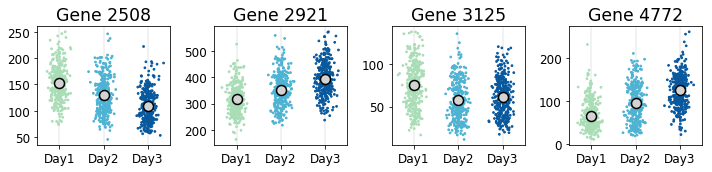

In [313]:
fig, axes = plt.subplots(1,4, figsize=(10,2.5))
top_genes = np.argsort(dremi_scores)[::-1]

for i, ax in enumerate(axes.flatten()):
    scprep.plot.jitter(sample, data_ln.iloc[:,top_genes[i+4]], s=3,
                       ax=ax, title='Gene {}'.format(top_genes[i]),
                      means_c='lightgrey', c=sample, cmap=cmap, legend=False)

fig.tight_layout()
fig.savefig('../img/graph_walk.simulation.expression.raw.png', dpi=300)

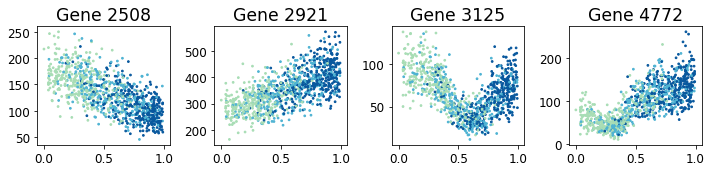

In [314]:
fig, axes = plt.subplots(1,4, figsize=(10,2.5))
top_genes = np.argsort(dremi_scores)[::-1]

for i, ax in enumerate(axes.flatten()):
    scprep.plot.scatter(all_dists, data_ln.iloc[:,top_genes[i+4]], s=3,
                       ax=ax, title='Gene {}'.format(top_genes[i]),
                       c=sample, cmap=cmap, legend=False)

fig.tight_layout()
fig.savefig('../img/graph_walk.simulation.expression.pseduotime.png', dpi=300)

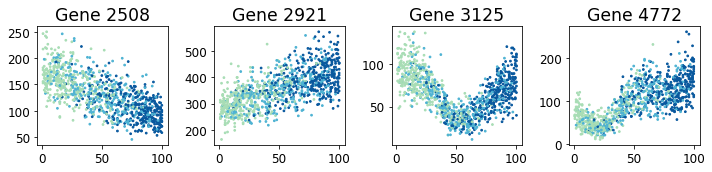

In [315]:
fig, axes = plt.subplots(1,4, figsize=(10,2.5))
top_genes = np.argsort(dremi_scores)[::-1]

for i, ax in enumerate(axes.flatten()):
    scprep.plot.scatter(metadata['step'], data_ln.iloc[:,top_genes[i+4]], s=3,
                       ax=ax, title='Gene {}'.format(top_genes[i]),
                       c=sample, cmap=cmap, legend=False)

fig.tight_layout()
fig.savefig('../img/graph_walk.simulation.expression.true_ordered.png', dpi=300)

In [451]:
import scprep

# Splatter parameters
# cells_per_path * n_groupsnp.tile(1/n_groups, n_groups)
n_groups = 3
cells_per_path = 1000
params = {'method':'paths', 'batch_cells':cells_per_path * n_groups, 'seed':42, 
         'group_prob':np.tile(1/n_groups, n_groups), 'path_from':[0,0,0], 'n_genes':5000,
         'de_fac_loc':[0.4,0.15,0.4]}

# Run Splatter
results = scprep.run.SplatSimulate(**params)

# Assign data to data frame
data = pd.DataFrame(results['true_counts'])

metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).T
metadata = metadata.astype({'step': int})

# Sort metadata by step
metadata = metadata.sort_values('step')

# Sort data
data = data.loc[metadata.index]

# Reindex
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

data_ln = scprep.normalize.library_size_normalize(data)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


In [452]:
steps = metadata['step'].copy()
m = np.isin(metadata['group'], ['Path1'])
steps[m] = 100 - steps[m]

m = np.isin(metadata['group'], ['Path2', 'Path3'])
steps[m] = 100 + steps[m]

In [453]:
G_branch = gt.Graph(data_ln, n_pca=100, use_pygsp=True)

In [525]:
import anndata, scanpy

adata = anndata.AnnData(data_ln)

adata.uns['iroot'] = 2977

scanpy.pp.neighbors(adata)
scanpy.tl.diffmap(adata)
scanpy.tl.dpt(adata)

dpt = adata.obs['dpt_pseudotime']

In [454]:
class DiffusionPseudotime():
    
    def fit(data)
        G = gt.Graph(data, n_pca=100, use_pygsp=True)
        
        # Calculate eigenvectors of the diffusion operator
        # May be faster way to do this
        W, V = sparse.linalg.eigs(G.diff_op, k=1)
        
        # Remove first eigenspace
        V_tilde = G.diff_op.toarray() - (V[:,0] @ V[:,0].T)
        
        # Calculate M
        T = V_tilde
        I = np.eye(T.shape[1])
        M = np.linalg.inv(I - T) - I
        
        # Calc DPT
        DPT = squareform(pdist(M))
        
        self.DPT = DPT
        return DPT
    
    def transform(root_cell):
        self.pseudotime = self.DPT[root_cell]
        return self.pseudotime
    
    def calculate_inverse_pseudotime(end_cell):
        self.inv_pseudotime = self.DPT[end_cell]
        return self.inv_pseudotime
    
    def fit_transform(data, root_cell):
        self.fit(data)
        return self.transform(root_cell)

In [455]:
data_pca = PCA(2).fit_transform(np.sqrt(data_ln))

In [467]:
steps / np.max(steps)

200

In [475]:
sample = np.random.binomial(2, steps / np.max(steps), size=steps.shape[0])
sample = ['Day{}'.format(i+1) for i in sample]


sample_cmap = {'Day1' : '#a8ddb5',
       'Day2': '#4eb3d3',
       'Day3': '#08589e'}

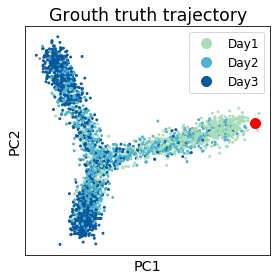

In [500]:
fig, ax = plt.subplots(1, figsize=(4,4))

start_cell = np.argsort(steps.values)[3]
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c =sample, cmap=sample_cmap, 
                      ticks=None, title='Grouth truth trajectory', 
                      legend=True, label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.sample_labels.png', dpi=300)

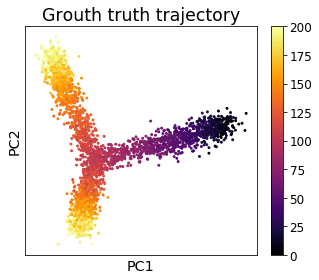

In [539]:
ax = scprep.plot.scatter2d(data_pca, label_prefix='PC', c=steps,
                      ticks=None, title='Grouth truth trajectory', 
                      discrete=False, legend=True,
                     figsize=(4.6,4))
ax.figure.tight_layout()
ax.figure.savefig('../img/diffusion.simulation.ground_truth_trajectory.png', dpi=300)

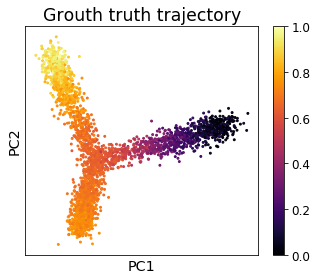

In [541]:
ax = scprep.plot.scatter2d(data_pca, label_prefix='PC', c=dpt,
                      ticks=None, title='Grouth truth trajectory', 
                      discrete=False, legend=True,
                     figsize=(4.6,4))
ax.figure.tight_layout()
#ax.figure.savefig('../img/diffusion.simulation.ground_truth_trajectory.png', dpi=300)

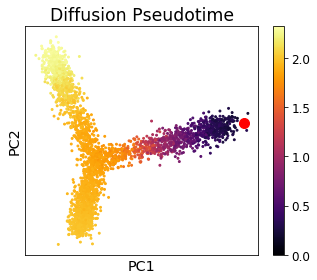

In [503]:


fig, ax = plt.subplots(1, figsize=(4.6,4))
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c = DPT[start_cell], 
                      ticks=None, title='Diffusion Pseudotime', 
                      discrete=False, legend=True,label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.dpt.png', dpi=300)

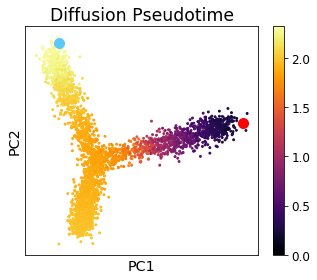

In [507]:
fig, ax = plt.subplots(1, figsize=(4.6,4))
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

end_cell = np.argmax(DPT[start_cell])
ax.scatter(data_pca[end_cell,0], data_pca[end_cell,1], color=[90/255, 200/255, 250/255], s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c = DPT[start_cell], 
                      ticks=None, title='Diffusion Pseudotime', 
                      discrete=False, legend=True,label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.dpt2.png', dpi=300)

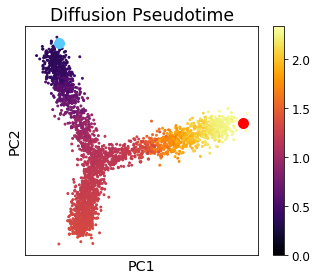

In [508]:
fig, ax = plt.subplots(1, figsize=(4.6,4))
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

end_cell = np.argmax(DPT[start_cell])
ax.scatter(data_pca[end_cell,0], data_pca[end_cell,1], color=[90/255, 200/255, 250/255], s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c = DPT[end_cell], 
                      ticks=None, title='Diffusion Pseudotime', 
                      discrete=False, legend=True,label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.dpt3.png', dpi=300)

In [521]:
import scipy

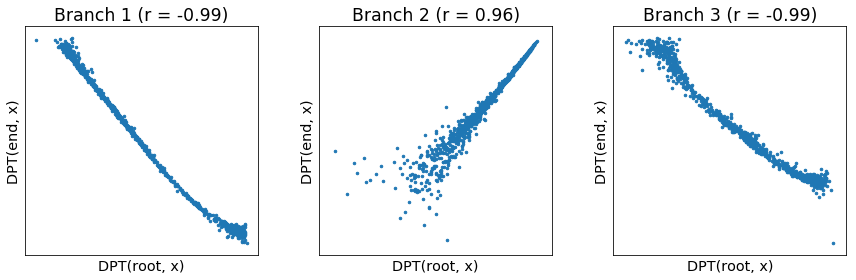

In [524]:
fig, axes = plt.subplots(1,3 ,figsize=(12,4))

for i, ax in enumerate(axes):
    g = sorted(metadata['group'].unique())[i]
    m = metadata['group'] == g
    
    x = DPT[start_cell][m]
    y = DPT[end_cell][m]
    r, p = scipy.stats.pearsonr(x,y)
    scprep.plot.scatter(DPT[start_cell][m], DPT[end_cell][m], 
                        ticks=None, xlabel='DPT(root, x)', ylabel='DPT(end, x)',
                        title='Branch {} (r = {:.2f})'.format(i+1, r),
                        ax=ax)
    
    
    
fig.tight_layout(w_pad=4)
fig.savefig('../img/diffusion.simulation.corr_anticorr.png', dpi=300)

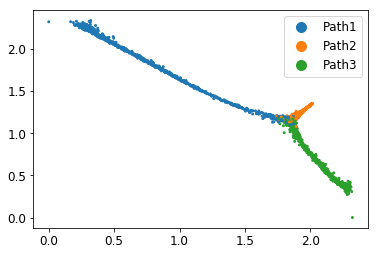

In [510]:
scprep.plot.scatter(DPT[start_cell], DPT[end_cell], c=metadata['group'])

In [3]:
import scprep

# Splatter parameters
# cells_per_path * n_groupsnp.tile(1/n_groups, n_groups)
n_groups = 9
cells_per_path = 1000
params = {'method':'paths', 'batch_cells':cells_per_path * n_groups, 'seed':42, 
         'group_prob':np.tile(1/n_groups, n_groups), 'path_from':[0,1,1,2,2,3,3,4,4], 'n_genes':5000,
         'de_fac_loc':0.2}

# Run Splatter
results = scprep.run.SplatSimulate(**params)

# Assign data to data frame
data = pd.DataFrame(results['true_counts'])

metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).T
metadata = metadata.astype({'step': int})



# Reindex
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

data_ln = scprep.normalize.library_size_normalize(data)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


In [8]:
data_pca = PCA(100).fit_transform(np.sqrt(data_ln))

In [9]:
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_pca)

Calculating PHATE...
  Running PHATE on 10000 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 14.10 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 14.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.00 seconds.
    Calculating KMeans...
    Calculated KMeans in 40.65 seconds.
  Calculated landmark operator in 43.71 seconds.
  Calculating optimal t...
    Automatically selected t = 5
  Calculated optimal t in 3.70 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 21.23 seconds.
Calculated PHATE in 84.16 seconds.


In [11]:
import umap

In [12]:
data_umap = umap.UMAP().fit_transform(data_pca)

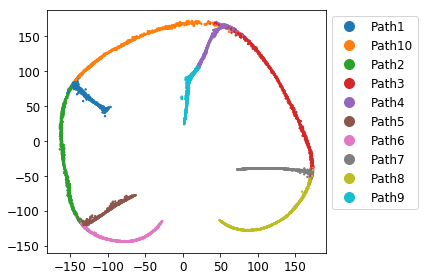

In [18]:
scprep.plot.scatter2d(data_phate, c=metadata['group'], legend_anchor=(1,1))

In [29]:
idx = metadata['step'].loc[metadata['group'] == 'Path1'].idxmin()
idx = np.where(metadata.index == idx)[0][0]

In [30]:
import anndata, scanpy

adata = anndata.AnnData(data_ln)

adata.uns['iroot'] = idx

scanpy.pp.neighbors(adata)
scanpy.tl.diffmap(adata)
scanpy.tl.dpt(adata)

dpt = adata.obs['dpt_pseudotime']

Transforming to str index.


         Falling back to preprocessing with `sc.pp.pca` and default params.


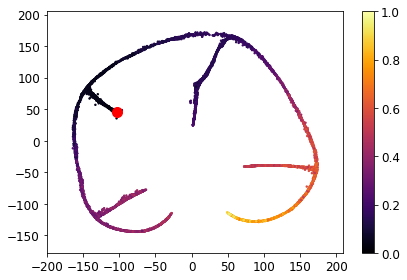

In [35]:
ax = scprep.plot.scatter2d(data_phate, c=dpt, legend_anchor=(1,1))
ax.scatter(data_phate[idx, 0], data_phate[idx, 1], color='red', s=100, zorder=10)

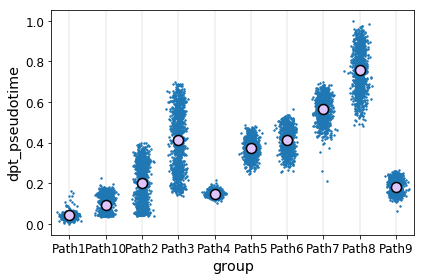

In [36]:
scprep.plot.jitter(metadata['group'], dpt)